# Traveltime tomography using the Eikonal equation (2D case)

@Author: Ettore Biondi - ebiondi@caltech.edu


To use this notebook, we need pykonal installed.
1. `conda env create -n occa -f ../env.yml`
2. `conda activate occa`
2. `conda install cython`
3. `wget https://codeload.github.com/malcolmw/pykonal/zip/refs/tags/0.2.3b3`
4. `unzip 0.2.3b3 && rm 0.2.3b3`
5. `pip install -e pykonal-0.2.3b3`

In [16]:
import numpy as np
import occamypy as o
import eikonal2d as k

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'jet_r',
    'image.aspect'   : 'auto',
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

In [2]:
# Fast-Marching-Method (FMM)
dx = dz = 0.1
nx, nz = 201, 101
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)

# Velocity model
vv = o.VectorNumpy((nx,nz), ax_info=[o.AxInfo(nx, 0, dx, "x [km]"), o.AxInfo(nz, 0, dz, "z [km]")])
vv[:] = 1. + 0.1*z

In [3]:
# Source/Receiver positions
SouPos = np.array([[0,nz-1], [int(nx/2), nz-1], [nx-1, nz-1]])
RecPos = np.array([[ix,0] for ix in np.arange(0,nx)])

# Data vector
tt_data = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]),
                        ax_info=[o.AxInfo(SouPos.shape[0], 0, 1, "rec_id"), vv.ax_info[0]])
tt_data.zero()

# Setting Forward non-linear operator
Eik2D_Op = k.EikonalTT_2D(vv, tt_data, SouPos, RecPos)
Eik2D_Op.forward(False, vv, tt_data)

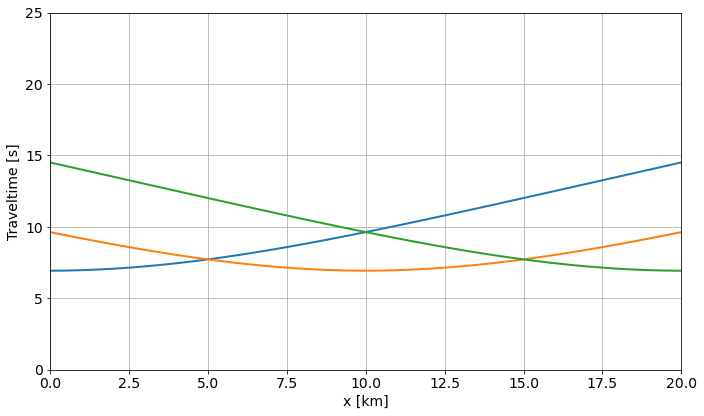

In [4]:
# Plotting traveltime vector
fig, ax = plt.subplots()
ax.plot(tt_data.ax_info[1].plot(), tt_data[0], lw=2)
ax.plot(tt_data.ax_info[1].plot(), tt_data[1], lw=2)
ax.plot(tt_data.ax_info[1].plot(), tt_data[2], lw=2)
ax.grid()
plt.xlabel(tt_data.ax_info[1].l)
plt.ylabel("Traveltime [s]")
ax.set_ylim(0, 25)
ax.set_xlim(tt_data.ax_info[1].o, tt_data.ax_info[1].last)
plt.tight_layout()
plt.show()

In [5]:
# Dot-product test for the linearized Eikonal equation in 1D
Eik2D_Lin_Op = k.EikonalTT_lin_2D(vv, tt_data, SouPos, RecPos)
Eik2D_Lin_Op.dotTest(True)

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 2.1434388160705566 seconds
Applying adjoint operator add=False
 Runs in: 3.4574429988861084 seconds
Dot products add=False: domain=1.317691e+00 range=1.317691e+00 
Absolute error: 0.000000e+00
Relative error: 0.000000e+00 

Applying forward operator add=True
 Runs in: 0.17281413078308105 seconds
Applying adjoint operator add=True
 Runs in: 0.5983438491821289 seconds
Dot products add=True: domain=2.635382e+00 range=2.635382e+00 
Absolute error: 8.881784e-16
Relative error: 3.370208e-16 

-------------------------------------------------


## Inversion

In [6]:
# Fast-Marching-Method (FMM)
# dx = dz = 0.05
dx = dz = 0.1
nx, nz = 201, 101
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)

# Background Velocity model
vv0 = o.VectorNumpy((nx,nz), ax_info=[o.AxInfo(nx, 0, dx, "x [km]"), o.AxInfo(nz, 0, dz, "z [km]")])
vv0[:] = 1.0 + z*0.1

# Gaussian anomaly
zz, xx = np.meshgrid(z, x)
dst = np.sqrt(xx*xx+zz*zz)
sigma = 1.0
xloc = 101*dx
zloc = 51*dz
gauss = np.exp(-( ((xx-xloc)**2 + (zz-zloc)**2) / (2.0*sigma**2)))
# Constructing true model
vv = vv0.clone()
vv[:] -= gauss*0.5

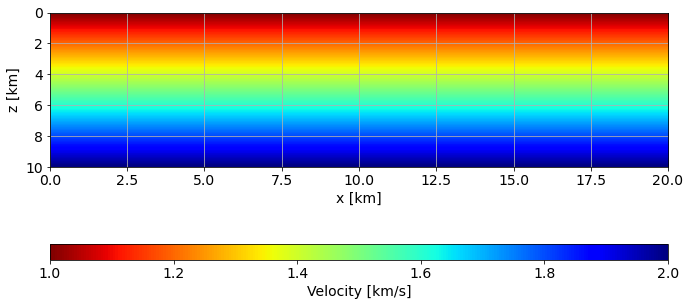

In [7]:
fig, ax = plt.subplots()
im = ax.imshow(vv0.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(vv0.ax_info[0].l)
plt.ylabel(vv0.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

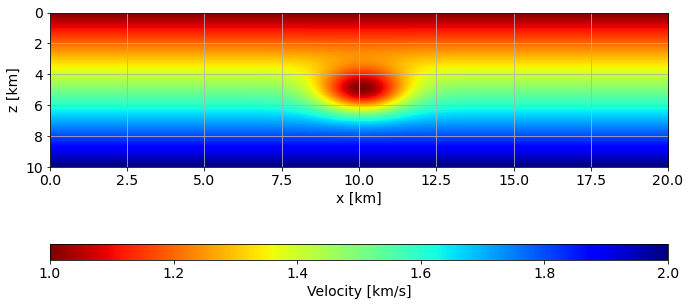

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(vv.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(vv.ax_info[0].l)
plt.ylabel(vv.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

In [9]:
# Source/Receiver positions
SouPos = np.array([[ix,nz-1] for ix in np.arange(0,nx,20)])
RecPos = np.array([[ix,0] for ix in np.arange(0,nx)])

# Data vector
tt_data = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]),
                        ax_info=[o.AxInfo(SouPos.shape[0], 0, 1, "rec_id"), vv.ax_info[0]])

# Instantiating non-linear operator
Eik2D_Op = k.EikonalTT_2D(vv, tt_data, SouPos, RecPos)
Eik2D_Lin_Op = k.EikonalTT_lin_2D(vv, tt_data, SouPos, RecPos, tt_maps=Eik2D_Op.tt_maps)
Eik2D_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op, Eik2D_Lin_Op.set_vel)

In [10]:
# Creating observed data
Eik2D_Op.forward(False, vv, tt_data)
tt_data_obs = tt_data.clone()

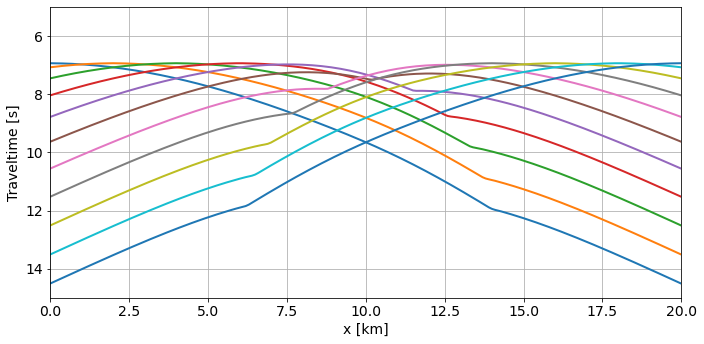

In [11]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(10,5))
for ids in range(SouPos.shape[0]):
    ax.plot(tt_data.ax_info[1].plot(), tt_data[ids], lw=2)
ax.grid()
plt.xlabel(tt_data.ax_info[1].l)
plt.ylabel("Traveltime [s]")
ax.set_ylim(5.0, 15.0)
ax.set_xlim(tt_data.ax_info[1].o, tt_data.ax_info[1].last)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
# instantiate solver
BFGSBsolver = o.LBFGS(o.BasicStopper(niter=25, tolg_proj=1e-32), m_steps=30)

# Creating problem object using Smoothing filter
G = o.GaussianFilter(vv0, 1.5)

Eik2D_Inv_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op * G, Eik2D_Lin_Op.set_vel)

L2_tt_prob = o.NonlinearLeastSquares(vv0.clone(), tt_data_obs, Eik2D_Inv_NlOp, 
                                     minBound=vv0.clone().set(1.),  # min velocity: 1 km/s
                                     maxBound=vv0.clone().set(2.5)) # max velocity: 2.5 km/s

In [13]:
BFGSBsolver.run(L2_tt_prob, verbose=True)

##########################################################################################
Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) algorithm 
Maximum number of steps to be used for Hessian inverse estimation: 30 
Restart folder: /tmp/restart_2022-03-29T16-16-46.534971/
##########################################################################################

iter = 00, obj = 2.48052e+01, resnorm = 7.04e+00, gradnorm = 8.73e+00, feval = 1, geval = 1
iter = 01, obj = 8.19519e+00, resnorm = 4.05e+00, gradnorm = 5.07e+00, feval = 2, geval = 2
iter = 02, obj = 2.58445e+00, resnorm = 2.27e+00, gradnorm = 1.52e+00, feval = 3, geval = 3
iter = 03, obj = 1.23840e+00, resnorm = 1.57e+00, gradnorm = 9.19e-01, feval = 4, geval = 4
iter = 04, obj = 3.15355e-01, resnorm = 7.94e-01, gradnorm = 4.07e-01, feval = 5, geval = 5
iter = 05, obj = 2.03645e-01, resnorm = 6.38e-01, gradnorm = 2.46e-01, feval = 6, geval = 6
iter = 06, obj = 9.79590e-02, resnorm = 4.43e-01, gradnorm = 1.75e-01

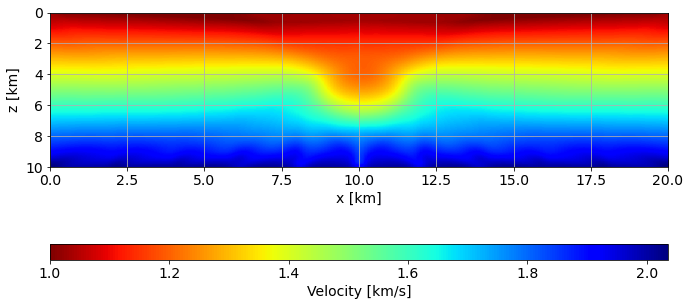

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(L2_tt_prob.model.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(L2_tt_prob.model.ax_info[0].l)
plt.ylabel(L2_tt_prob.model.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()